In [1]:
"""!pip install opencv-python
!pip install moviepy
"""

'!pip install opencv-python\n!pip install moviepy\n'

In [2]:
# import part
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from moviepy.editor import VideoFileClip

#test 
%matplotlib inline


In [3]:
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    return np.sum(bottom_half, axis=0)

class LaneLines:
    """ Class containing information about detected lane lines.

    Attributes:
        left_fit (np.array): Coefficients of a polynomial that fit left lane line
        right_fit (np.array): Coefficients of a polynomial that fit right lane line
        parameters (dict): Dictionary containing all parameters needed for the pipeline
        debug (boolean): Flag for debug/normal mode
    """
    def __init__(self):
        """Init Lanelines.

        Parameters:
            left_fit (np.array): Coefficients of polynomial that fit left lane
            right_fit (np.array): Coefficients of polynomial that fit right lane
            binary (np.array): binary image
        """
        self.left_fit = None
        self.right_fit = None
        self.binary = None
        self.nonzero = None
        self.nonzerox = None
        self.nonzeroy = None
        self.clear_visibility = True
        self.dir = []
        self.left_curve_img = mpimg.imread('left_turn.png')
        self.right_curve_img = mpimg.imread('right_turn.png')
        self.keep_straight_img = mpimg.imread('straight.png')
        self.left_curve_img = cv2.normalize(src=self.left_curve_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        self.right_curve_img = cv2.normalize(src=self.right_curve_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        self.keep_straight_img = cv2.normalize(src=self.keep_straight_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        # HYPERPARAMETERS
        # Number of sliding windows
        self.nwindows = 9
        # Width of the the windows +/- margin
        self.margin = 100
        # Mininum number of pixels found to recenter window
        self.minpix = 50

    def forward(self, img):
        """Take a image and detect lane lines.

        Parameters:
            img (np.array): An binary image containing relevant pixels

        Returns:
            Image (np.array): An RGB image containing lane lines pixels and other details
        """
        self.extract_features(img)
        return self.fit_poly(img)

    def pixels_in_window(self, center, margin, height):
        """ Return all pixel that in a specific window

        Parameters:
            center (tuple): coordinate of the center of the window
            margin (int): half width of the window
            height (int): height of the window

        Returns:
            pixelx (np.array): x coordinates of pixels that lie inside the window
            pixely (np.array): y coordinates of pixels that lie inside the window
        """
        topleft = (center[0]-margin, center[1]-height//2)
        bottomright = (center[0]+margin, center[1]+height//2)

        condx = (topleft[0] <= self.nonzerox) & (self.nonzerox <= bottomright[0])
        condy = (topleft[1] <= self.nonzeroy) & (self.nonzeroy <= bottomright[1])
        return self.nonzerox[condx&condy], self.nonzeroy[condx&condy]

    def extract_features(self, img):
        """ Extract features from a binary image

        Parameters:
            img (np.array): A binary image
        """
        self.img = img
        # Height of of windows - based on nwindows and image shape
        self.window_height = np.int(img.shape[0]//self.nwindows)
        # Identify the x and y positions of all nonzero pixel in the image
        self.nonzero = img.nonzero()
        self.nonzerox = np.array(self.nonzero[1])
        self.nonzeroy = np.array(self.nonzero[0])

    def find_lane_pixels(self, img):
        """Find lane pixels from a binary warped image.

        Parameters:
            img (np.array): A binary warped image

        Returns:
            leftx (np.array): x coordinates of left lane pixels
            lefty (np.array): y coordinates of left lane pixels
            rightx (np.array): x coordinates of right lane pixels
            righty (np.array): y coordinates of right lane pixels
            out_img (np.array): A RGB image that use to display result later on.
            
        """
        assert(len(img.shape) == 2)
        # Create an output image to draw on and visualize the result 
        out_img = np.dstack((img, img, img))

        histogram = hist(img)
        midpoint = histogram.shape[0]//2
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Current position to be update later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base
        y_current = img.shape[0] + self.window_height//2

        # Create empty lists to reveice left and right lane pixel
        leftx, lefty, rightx, righty = [], [], [], []

        # Step through the windows one by one
        for _ in range(self.nwindows):
            y_current -= self.window_height
            center_left = (leftx_current, y_current)
            center_right = (rightx_current, y_current)

            good_left_x, good_left_y = self.pixels_in_window(center_left, self.margin, self.window_height)
            good_right_x, good_right_y = self.pixels_in_window(center_right, self.margin, self.window_height)

            # Append these indices to the lists
            leftx.extend(good_left_x)
            lefty.extend(good_left_y)
            rightx.extend(good_right_x)
            righty.extend(good_right_y)

            if len(good_left_x) > self.minpix:
                leftx_current = np.int32(np.mean(good_left_x))
            if len(good_right_x) > self.minpix:
                rightx_current = np.int32(np.mean(good_right_x))

        return leftx, lefty, rightx, righty, out_img

    def fit_poly(self, img):
        """Find the lane line from an image and draw it.

        Parameters:
            img (np.array): a binary warped image

        Returns:
            out_img (np.array): a RGB image that have lane line drawn on that.
        """

        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(img)

        if len(lefty) > 1500:
            self.left_fit = np.polyfit(lefty, leftx, 2)
        if len(righty) > 1500:
            self.right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        maxy = img.shape[0] - 1
        miny = img.shape[0] // 3
        if len(lefty):
            maxy = max(maxy, np.max(lefty))
            miny = min(miny, np.min(lefty))

        if len(righty):
            maxy = max(maxy, np.max(righty))
            miny = min(miny, np.min(righty))

        ploty = np.linspace(miny, maxy, img.shape[0])

        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        # Visualization to drwa two lines and green in street 
        for i, y in enumerate(ploty):
            l = int(left_fitx[i])
            r = int(right_fitx[i])
            y = int(y)
            cv2.line(out_img, (l, y), (r, y), (0, 255, 0))
            cv2.line(out_img,(l,y),(l+20,y),(25,25,112),15)
            cv2.line(out_img,(r-20,y),(r,y),(25,25,112),15)
            

        lR, rR, pos = self.measure_curvature()

        return out_img

    def plot(self, out_img):
        np.set_printoptions(precision=6, suppress=True)
        lR, rR, pos = self.measure_curvature()

        value = None
        if abs(self.left_fit[0]) > abs(self.right_fit[0]):
            value = self.left_fit[0]
        else:
            value = self.right_fit[0]

        if abs(value) <= 0.00015:
            self.dir.append('F')
        elif value < 0:
            self.dir.append('L')
        else:
            self.dir.append('R')
        
        if len(self.dir) > 10:
            self.dir.pop(0)

        W = 400
        H = 500
        widget = np.copy(out_img[:H, :W])
        widget //= 2
        widget[0,:] = [0, 0, 255]
        widget[-1,:] = [0, 0, 255]
        widget[:,0] = [0, 0, 255]
        widget[:,-1] = [0, 0, 255]
        out_img[:H, :W] = widget

        direction = max(set(self.dir), key = self.dir.count)
        msg = "Keep Straight Ahead"
        curvature_msg = "Curvature = {:.0f} m".format(min(lR, rR))
        
        if direction == 'L':
        
            y, x = self.left_curve_img[:,:,3].nonzero()
            out_img[y, x-100+W//2] = self.left_curve_img[y, x, :3]
            msg = "Left Curve Ahead"
            
        if direction == 'R':
            y, x = self.right_curve_img[:,:,3].nonzero()
            out_img[y, x-100+W//2] = self.right_curve_img[y, x, :3]
            msg = "Right Curve Ahead"
        if direction == 'F':
            y, x = self.keep_straight_img[:,:,3].nonzero()
            out_img[y, x-100+W//2] = self.keep_straight_img[y, x, :3]

        cv2.putText(out_img, msg, org=(10, 240), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)
        
        if direction in 'LR':
            cv2.putText(out_img, curvature_msg, org=(10, 280), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

        cv2.putText(
            out_img,
            "Good Lane Keeping",
            org=(10, 400),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1.2,
            color=(0, 255, 0),
            thickness=2)

        cv2.putText(
            out_img,
            "Vehicle is {:.2f} m away from center".format(pos),
            org=(10, 450),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.66,
            color=(255, 255, 255),
            thickness=2)
        
        return out_img

    def measure_curvature(self):
        ym = 30/720
        xm = 3.7/700

        left_fit = self.left_fit.copy()
        right_fit = self.right_fit.copy()
        y_eval = 700 * ym

        # Compute R_curve (radius of curvature)
        left_curveR =  ((1 + (2*left_fit[0] *y_eval + left_fit[1])**2)**1.5)  / np.absolute(2*left_fit[0])
        right_curveR = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

        xl = np.dot(self.left_fit, [700**2, 700, 1])
        xr = np.dot(self.right_fit, [700**2, 700, 1])
        pos = (1280//2 - (xl+xr)//2)*xm
        return left_curveR, right_curveR, pos 


In [4]:

def plt_images(orig_image, orig_title, processed_image, processed_title, cmap='gray'):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    ax1.set_title(orig_title, fontsize=30)
    ax1.imshow(orig_image)
    ax2.set_title(processed_title, fontsize=30)
    ax2.imshow(processed_image, cmap='gray')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# instance in case we need it later  
    #plt_images(orig_image, orig_title, processed_image, processed_title, cmap='gray')


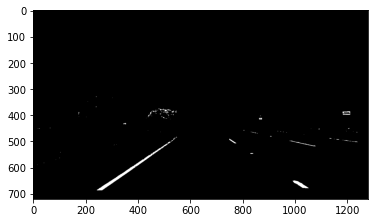

In [5]:
#threshold
def threshold_rel(img, lo, hi):
    vmin = np.min(img)
    vmax = np.max(img)
    vlo = vmin + (vmax - vmin) * lo
    vhi = vmin + (vmax - vmin) * hi
    return np.uint8((img >= vlo) & (img <= vhi)) * 255

def threshold_abs(img, lo, hi):
    return np.uint8((img >= lo) & (img <= hi)) * 255
def thresholding (img1):
    hls = cv2.cvtColor(img1, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]
  

    right_lane = threshold_rel(l_channel, 0.8, 1.0)
    right_lane[:,:750] = 0

    left_lane = threshold_abs(h_channel, 20, 30)
    left_lane &= threshold_rel(v_channel, 0.7, 1.0)
    left_lane[:,550:] = 0
    img2 = left_lane | right_lane
    x=  threshold_rel(l_channel, 0.8, 1.0)
    x = np.dstack((x,x,x))
    return img2, x
#test
imgg = mpimg.imread('test_images/straight_lines1.jpg')
imggg,l_channel=thresholding(imgg)
plt.imshow(imggg, vmin=0, vmax=255, cmap='gray')
#plt.imshow(imggg)



In [6]:
#""" This a function for transforming image between front view and top view "bird eye"
 #       src (np.array): Coordinates of 4 source points
  #      dst (np.array): Coordinates of 4 destination points
   #     M (np.array): Matrix to transform image from front view to top view
    #    M_inv (np.array): Matrix to transform image from top view to front view
    #"""
def PerspectiveTransformation(image):
    src = np.float32([(550, 460),     # top-left
                      (150, 720),     # bottom-left
                      (1200, 720),    # bottom-right
                      (770, 460)])    # top-right
    dst = np.float32([(100, 0),
                      (100, 720),
                     (1100, 720),
                       (1100, 0)])
  
 
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return M,M_inv
# Take a front view image and transform to top view"""
def forward(img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
    
    M,M_inv=PerspectiveTransformation(img)
    return cv2.warpPerspective(img, M, img_size, flags=flags)
     #Take a top view image and transform it to front view"""
def backward(img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
    M,M_inv=PerspectiveTransformation(img)
    return cv2.warpPerspective(img, M_inv, img_size, flags=flags)
    
    


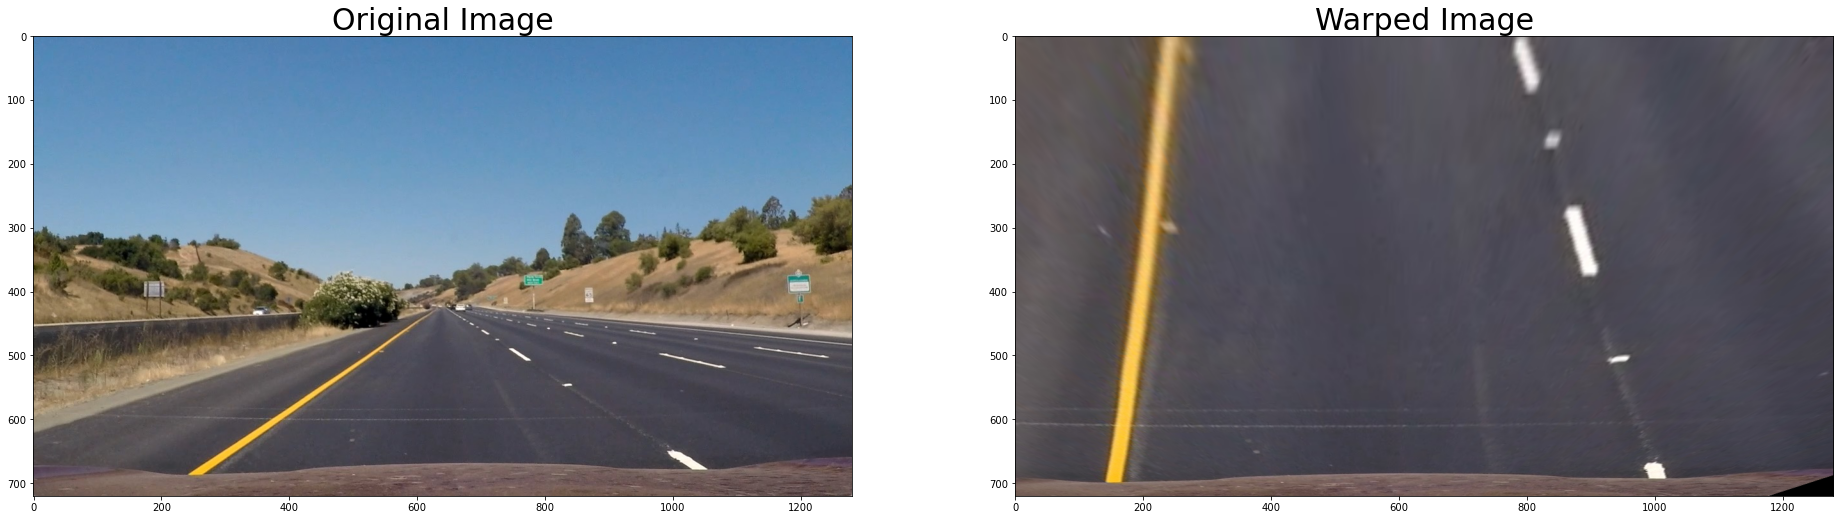

In [7]:
#test
# Test Binary Function
img = mpimg.imread('test_images/straight_lines1.jpg')
warped= forward(img)
plt_images(img,'Original Image',warped, 'Warped Image')


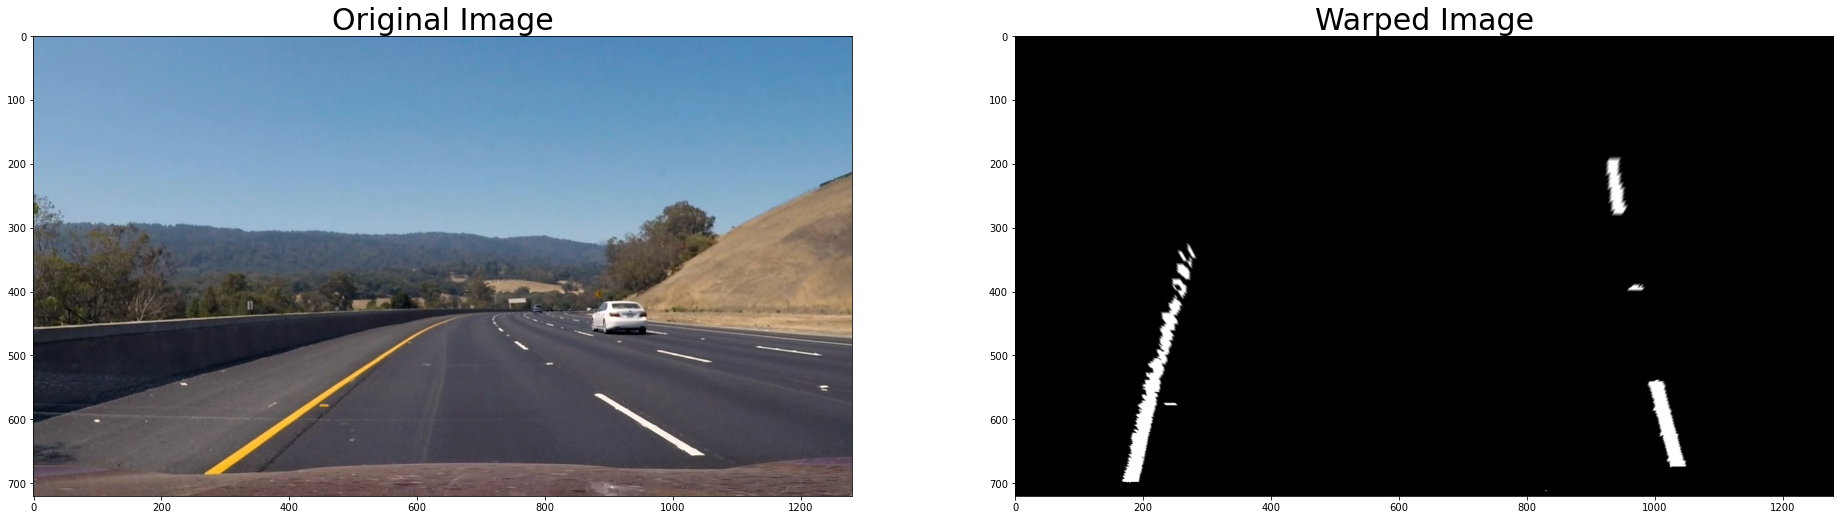

In [8]:
#test after thresholding and warped 
img = mpimg.imread('test_images/test3.jpg')
img2,l=thresholding(img)
warped= forward(img2)
plt_images(img,'Original Image',warped, 'Warped Image')


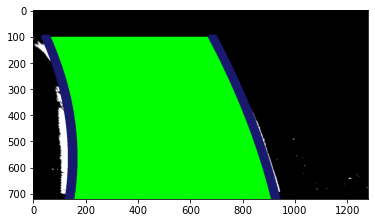

In [9]:
#test lane lines
img= mpimg.imread('test_images/harder_challenge_video_frame_10.jpg')
im,l=thresholding(img)
im= forward(im)
lanelines = LaneLines()
img3 = lanelines.forward(im)
plt.imshow(img3)

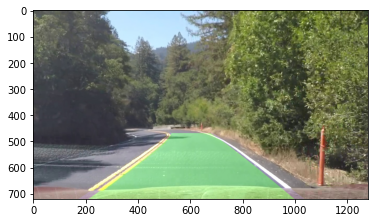

In [10]:
#after added on original
img4 =backward(img3) #front view
out_img = cv2.addWeighted(img, 1, img4, 0.3, 0)
plt.imshow(out_img)

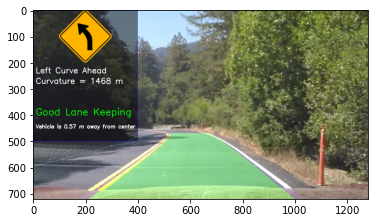

In [11]:
#after added on window for details
out_img = lanelines.plot(out_img)
plt.imshow(out_img)

In [12]:
lanelines = LaneLines()
# debugging mode 0
def process_image_debug(img):
    # step 1
    img1 = forward(img)

   #img1 = np.copy(img)
   #step 2
    img2,x=thresholding(img1)
    x,l_channel = thresholding(img)
    im= np.dstack((img2, img2, img2))
    imgg1 = np.concatenate((l_channel, img1), axis=0)#first
    imgg1=cv2.resize(imgg1,(720,720))
   
  
  #  img2 = birdeye.forward(img2) 
    # step 3
    img3 = lanelines.forward(img2)
    imgg = np.concatenate((im, img3), axis=0)#second
    imgg=cv2.resize(imgg,(720,720))
    
    imgg = np.concatenate((imgg1, imgg), axis = 1)
    # step 4
    img4 = backward(img3)
    out_img = cv2.addWeighted(img, 1, img4, 1, 0)
    out_img = lanelines.plot(out_img)
    out_img = np.concatenate((out_img, imgg), axis=1)
   
   
    return out_img
# lane video only 1
def process_image(img):
     # step 1
    img1 = forward(img)

   #img1 = np.copy(img)
   #step 2
    img2,x=thresholding(img1) 
    # step 3
    img3 = lanelines.forward(img2)
   
    # step 4
    img4 = backward(img3)
    out_img = cv2.addWeighted(img, 1, img4, 1, 0)
    out_img = lanelines.plot(out_img) # add lanes to the original image
   
    return out_img

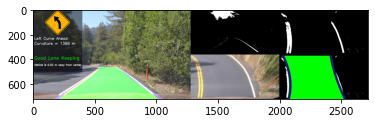

In [13]:
im=mpimg.imread('test_images/harder_challenge_video_frame_1.jpg')
tmp = process_image_debug(im)
plt.imshow(tmp)

In [75]:
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(process_image_debug)
out_clip.write_videofile("out_videos_with.mp4", audio=False)


Moviepy - Building video out_videos_with.mp4.
Moviepy - Writing video out_videos_with.mp4



Moviepy - Done !
Moviepy - video ready out_videos_with.mp4


In [76]:
clip = VideoFileClip("challenge_video.mp4")
out_clip = clip.fl_image(process_image)
out_clip.write_videofile("challenge_output_videos_without.mp4", audio=False)

Moviepy - Building video challenge_output_videos_without.mp4.
Moviepy - Writing video challenge_output_videos_without.mp4



Moviepy - Done !
Moviepy - video ready challenge_output_videos_without.mp4
